# Klasifikasi Spoken Arabic Digit dengan Metodologi CRISP-DM

**Oleh**: Data Science Student

**Dataset**: Spoken Arabic Digits (UCI Machine Learning Repository)

**Tujuan**: Membangun model machine learning untuk mengklasifikasikan digit berbahasa Arab (0-9) dari rekaman suara menggunakan MFCC features.

---

## Metodologi: CRISP-DM

1. **Business Understanding**
2. **Data Understanding**
3. **Data Preparation**
4. **Modeling**
5. **Evaluation**
6. **Deployment Preparation**

---
# 1. BUSINESS UNDERSTANDING

## 1.1 Tujuan Proyek
Mengembangkan sistem klasifikasi otomatis untuk mengenali 10 digit Arab (0-9) dari rekaman suara menggunakan fitur MFCC dan machine learning, yang dapat diintegrasikan ke aplikasi real-time seperti IVR, voice banking, dan smart home.

## 1.2 Tujuan Analisis
- Memahami pola fitur MFCC untuk setiap digit Arab dengan 13 koefisien per frame dan variable-length sequences (4-93 frame)
- Membangun model klasifikasi multi-class dengan performa balanced untuk semua 10 digit
- Membandingkan performa beberapa model: Machine Learning klasik (Decision Tree, Random Forest, KNN, SVM) dan Deep Learning (LSTM, 1D CNN)
- Menghasilkan model yang robust terhadap variasi speaker dan siap untuk deployment

## 1.3 Latar Belakang
Teknologi pengenalan suara menjadi kebutuhan penting, terutama untuk pasar berbahasa Arab yang mencakup lebih dari 400 juta orang. Sistem pengenalan digit Arab dari suara dibutuhkan untuk berbagai aplikasi seperti Interactive Voice Response (IVR) di call center, voice banking untuk transaksi hands-free, smart home untuk kontrol perangkat, dan aksesibilitas bagi pengguna dengan keterbatasan fisik. Analisis otomatis dapat meningkatkan efisiensi layanan, mengurangi waktu tunggu, dan memberikan pengalaman pengguna yang lebih natural.

## 1.4 Success Criteria
- **Akurasi keseluruhan ≥ 85%** (standar industri speech recognition)
- **F1-Score (macro) ≥ 0.85** (keseimbangan precision-recall untuk semua digit)
- **Min F1-Score per digit ≥ 0.75** (tidak ada digit yang terlalu buruk performanya)
- **Model stabil dan dapat di-deploy** (file size < 100 MB, inference time < 1 detik)

In [28]:
# Import libraries yang diperlukan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set style untuk visualisasi
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# Seed untuk reproducibility
np.random.seed(42)

# Set display options
pd.set_option('display.max_columns', None)

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


---
# 2. DATA UNDERSTANDING

## 2.1 Deskripsi Dataset

### Informasi Umum Dataset

**Nama Dataset:** Spoken Arabic Digits Dataset

**Sumber:** UCI Machine Learning Repository  
**Link:** https://archive.ics.uci.edu/ml/datasets/Spoken+Arabic+Digit

**Pemilik Data:** 
- M. Rushaidat (King Saud University, Riyadh, Saudi Arabia)
- Dikumpulkan untuk penelitian speech recognition

**Tahun:** 2012

---

### Isi Dataset

Dataset ini berisi **rekaman suara** orang mengucapkan angka 0-9 dalam bahasa Arab, yang sudah diekstrak menjadi **fitur MFCC** (bukan file audio mentah lagi).

**10 Digit Arab yang direkam:**

| Digit | Arab | Pengucapan | Transliterasi |
|-------|------|------------|---------------|
| 0 | صفر | Sifr | /sˤifr/ |
| 1 | واحد | Wahid | /waːħid/ |
| 2 | اثنان | Itnan | /ɪθˈneɪn/ |
| 3 | ثلاثة | Thalatha | /θalaːθa/ |
| 4 | أربعة | Arba'a | /ʔarbaʕa/ |
| 5 | خمسة | Khamsa | /xamsa/ |
| 6 | ستة | Sitta | /sɪtta/ |
| 7 | سبعة | Sab'a | /sabʕa/ |
| 8 | ثمانية | Thamaniya | /θamaːnɪja/ |
| 9 | تسعة | Tis'a | /tɪsʕa/ |

---

### Karakteristik Dataset

**Speakers (Pembicara):**
- **Jumlah:** 88 native Arabic speakers
- **Gender:** 44 laki-laki, 44 perempuan (balanced)
- **Background:** Penutur asli bahasa Arab
- **Variasi:** Berbagai aksen dan kecepatan bicara

**Recording Details:**
- **Repetisi:** Setiap speaker mengucapkan setiap digit **10 kali**
- **Sampling Rate:** 11,025 Hz (kualitas telephone)
- **Total Rekaman:** 88 speakers × 10 digits × 10 repetitions = **8,800 utterances**

**Feature Extraction:**
- Rekaman audio **sudah dikonversi** menjadi **MFCC features**
- Tidak ada file audio mentah (.wav) lagi
- Hasil: Time series berisi 13 koefisien MFCC per frame

---

### Struktur Data

**Format:** Time Series (Sequential Data)

**Dimensi:**
- **Timesteps (Frames):** Variable-length, berkisar 4-93 frame
  - Tergantung kecepatan bicara speaker
  - Orang ngomong cepat → sedikit frame (min: 4)
  - Orang ngomong lambat → banyak frame (max: 93)
  
- **Features per Frame:** 13 MFCC coefficients
  - Setiap frame = snapshot audio di waktu tertentu
  - 13 angka yang merepresentasikan karakteristik audio

**Contoh 1 Sample:**
```
Sample = Orang A ngomong "wahid" (1)

Frame 1: [MFCC-0, MFCC-1, ..., MFCC-12]  ← 13 angka
Frame 2: [MFCC-0, MFCC-1, ..., MFCC-12]  ← 13 angka
Frame 3: [MFCC-0, MFCC-1, ..., MFCC-12]  ← 13 angka
...
Frame 45: [MFCC-0, MFCC-1, ..., MFCC-12] ← 13 angka (misalnya ucapan ini 45 frame)

Label: 1
```

---

### Data Split

Dataset sudah **pre-split** menjadi training dan testing:

**Training Set:**
- **Jumlah:** 6,600 samples (75%)
- **Per digit:** 660 ucapan per digit
- **Fungsi:** Melatih model

**Test Set:**
- **Jumlah:** 2,200 samples (25%)
- **Per digit:** 220 ucapan per digit
- **Fungsi:** Menguji performa model pada data yang belum pernah dilihat

**Distribution:**
```
Total: 8,800 samples

Digit 0: 880 samples (660 train, 220 test)
Digit 1: 880 samples (660 train, 220 test)
...
Digit 9: 880 samples (660 train, 220 test)

✅ Perfectly Balanced!
```

---

### Apa itu MFCC? (Mel-Frequency Cepstral Coefficients)

**Definisi Sederhana:**  
MFCC = cara mengubah suara jadi angka yang bisa dianalisis komputer

**Analogi:**
- Seperti "sidik jari" dari suara
- Tangkap ciri khas suara: nada tinggi/rendah, warna suara, timbre, dll
- Compact representation: suara yang panjang → jadi 13 angka aja per frame

**Kenapa pakai MFCC untuk Speech Recognition?**

1. **Mirip Pendengaran Manusia**
   - MFCC meniru cara telinga manusia memproses suara
   - Menggunakan skala Mel (skala frekuensi yang sesuai dengan persepsi manusia)

2. **Compact & Efficient**
   - Mengurangi dimensi data tanpa kehilangan informasi penting
   - 13 koefisien cukup untuk merepresentasikan karakteristik suara

3. **Robust terhadap Noise**
   - Tahan terhadap background noise
   - Fokus pada karakteristik suara utama

4. **Standar Industri**
   - Digunakan di hampir semua aplikasi speech recognition
   - Terbukti efektif untuk berbagai bahasa dan aplikasi

**13 Koefisien MFCC:**
- **MFCC-0:** DC component (energi rata-rata)
- **MFCC-1 s/d MFCC-12:** Spektral shape (bentuk frekuensi suara)

---

### Preprocessing yang Sudah Dilakukan

**Audio → MFCC Conversion**
- Rekaman audio sudah diekstrak menjadi MFCC
- Tidak perlu proses signal processing lagi

**Segmentation**
- Audio sudah dipotong per ucapan (per digit)
- Setiap file = 1 ucapan 1 digit

**Labeling**
- Setiap sample sudah punya label (0-9)
- Manual labeling oleh peneliti

---

### Tantangan Dataset

**Variable-Length Sequences:**
- Panjang ucapan beda-beda (4-93 frame)
- **Solusi:** Padding semua jadi 93 frame

**Speaker Variability:**
- 88 speaker dengan aksen/intonasi berbeda
- **Dampak:** Model harus robust, tidak overfitting ke speaker tertentu

**Telephone Quality:**
- Sampling rate 11,025 Hz (lebih rendah dari CD quality 44,100 Hz)
- **Dampak:** Informasi frekuensi tinggi berkurang
- **Advantage:** Lebih realistis untuk aplikasi telepon/IVR

**Class Imbalance:**
- **Tidak ada!** Dataset perfectly balanced (880 sample per digit)
- Tidak perlu handling imbalance

---

### Kelebihan Dataset

 **Balanced:** Semua digit punya jumlah sample yang sama  
 **Gender Balanced:** 50% laki-laki, 50% perempuan  
 **Sufficient Size:** 8,800 samples cukup untuk training  
 **Pre-processed:** MFCC sudah diekstrak, siap pakai  
 **Clean Split:** Train-test split sudah tersedia  
 **Real Speakers:** Bukan synthetic, tapi rekaman orang asli  

---

### Keterbatasan Dataset

**Limited Speakers:** Hanya 88 orang  
   - Generalisasi ke speaker baru mungkin kurang optimal
   
**Single Recording Condition:**  
   - Environment yang sama untuk semua rekaman
   - Belum diuji dengan noise/background sound bervariasi
   
**No Demographic Info:**  
   - Tidak ada info umur, regional accent, pendidikan
   - Sulit analisis per demographic

**Telephone Quality Only:**  
   - Tidak ada high-quality recording
   - Suara natural (non-telephone) mungkin performa beda

### Tujuan Utama Dataset Spoken Arabic Digits
- Dataset ini dibuat untuk melatih dan menguji model pengenalan suara (speech recognition), khususnya untuk mengklasifikasikan angka Arab yang diucapkan (0–9) berdasarkan ciri-ciri audio.

---

## 2.2 Exploratory Data Analysis (EDA)

### Tujuan EDA

Exploratory Data Analysis dilakukan untuk:

1. **Memahami Struktur Data**
   - Berapa dimensi data (jumlah sample, timesteps, features)?
   - Apakah ada missing values atau anomali?
   - Bagaimana distribusi panjang sequences?

2. **Menganalisis Distribusi Kelas**
   - Apakah semua digit punya jumlah sample yang sama (balanced)?
   - Perlu handling imbalance atau tidak?

3. **Visualisasi Fitur MFCC**
   - Bagaimana pola MFCC untuk tiap digit?
   - Apakah ada perbedaan visual yang jelas?
   - Fitur mana yang paling informatif?

4. **Deteksi Outlier**
   - Apakah ada sample dengan nilai ekstrem?
   - Apakah ada ucapan yang terlalu pendek/panjang?

5. **Analisis Statistik Deskriptif**
   - Mean, median, std untuk setiap MFCC coefficient
   - Range values (min-max)
   - Distribusi nilai fitur

---


## 2.3 Load Dataset

In [29]:
# Import custom utility functions
from utils import load_train_test_data

# Load data
data_dir = 'data'

print("Loading dataset...")
X_train_raw, y_train, X_test_raw, y_test, max_length = load_train_test_data(data_dir)

print("\n" + "="*60)
print("DATASET LOADED SUCCESSFULLY")
print("="*60)

Loading dataset...
Loading training data from data/Train_Arabic_Digit.txt...
Loading test data from data/Test_Arabic_Digit.txt...
Maximum sequence length: 93

Dataset loaded successfully!
Training set: (6600, 93, 13)
Test set: (2200, 93, 13)
Training labels: 6600 (digits 0-9: [660 660 660 660 660 660 660 660 660 660])
Test labels: 2200 (digits 0-9: [220 220 220 220 220 220 220 220 220 220])

DATASET LOADED SUCCESSFULLY


## 2.4 Analisis Struktur Data

In [30]:
# Basic information
print("DATASET INFORMATION")
print("="*60)
print(f"Training samples: {len(X_train_raw)}")
print(f"Test samples: {len(X_test_raw)}")
print(f"Total samples: {len(X_train_raw) + len(X_test_raw)}")
print(f"\nFeature dimensions:")
print(f"  - Timesteps (max): {X_train_raw.shape[1]}")
print(f"  - MFCC coefficients: {X_train_raw.shape[2]}")
print(f"\nLabel distribution:")
print(f"  - Number of classes: {len(np.unique(y_train))}")
print(f"  - Classes: {sorted(np.unique(y_train).tolist())}")
print(f"  - Samples per class (train): {np.bincount(y_train.astype(int))}")
print(f"  - Samples per class (test): {np.bincount(y_test.astype(int))}")
print("="*60)

DATASET INFORMATION
Training samples: 6600
Test samples: 2200
Total samples: 8800

Feature dimensions:
  - Timesteps (max): 93
  - MFCC coefficients: 13

Label distribution:
  - Number of classes: 10
  - Classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
  - Samples per class (train): [660 660 660 660 660 660 660 660 660 660]
  - Samples per class (test): [220 220 220 220 220 220 220 220 220 220]


In [31]:
# Visualisasi struktur dataset dalam bentuk tabel
print("\n STRUKTUR DATASET DETAIL")
print("="*80)

# Buat DataFrame untuk Training Set
train_info = pd.DataFrame({
    'Aspect': [
        'Jumlah Samples',
        'Jumlah Timesteps (Frames)',
        'Jumlah Features per Frame',
        'Total Data Points',
        'Ukuran Array (Bytes)',
        'Ukuran Array (MB)',
        'Jumlah Kelas',
        'Samples per Kelas'
    ],
    'Training Set': [
        f'{X_train_raw.shape[0]:,}',
        f'{X_train_raw.shape[1]}',
        f'{X_train_raw.shape[2]} (MFCC coefficients)',
        f'{X_train_raw.size:,}',
        f'{X_train_raw.nbytes:,}',
        f'{X_train_raw.nbytes / (1024**2):.2f}',
        f'{len(np.unique(y_train))}',
        f'{X_train_raw.shape[0] // 10}'
    ],
    'Test Set': [
        f'{X_test_raw.shape[0]:,}',
        f'{X_test_raw.shape[1]}',
        f'{X_test_raw.shape[2]} (MFCC coefficients)',
        f'{X_test_raw.size:,}',
        f'{X_test_raw.nbytes:,}',
        f'{X_test_raw.nbytes / (1024**2):.2f}',
        f'{len(np.unique(y_test))}',
        f'{X_test_raw.shape[0] // 10}'
    ]
})

print(train_info.to_string(index=False))
print("="*80)

# Detail per digit
print("\n DISTRIBUSI DETAIL PER DIGIT")
print("="*80)
digit_dist = pd.DataFrame({
    'Digit': range(10),
    'Training Count': np.bincount(y_train.astype(int)),
    'Test Count': np.bincount(y_test.astype(int)),
    'Total': np.bincount(y_train.astype(int)) + np.bincount(y_test.astype(int)),
    'Percentage': [f'{((np.bincount(y_train.astype(int))[i] + np.bincount(y_test.astype(int))[i]) / 8800 * 100):.1f}%' for i in range(10)]
})
print(digit_dist.to_string(index=False))
print("="*80)

# Contoh data mentah
print("\n🔍 CONTOH DATA MENTAH (Sample pertama dari digit 0)")
print("="*80)
print(f"Shape: {X_train_raw[0].shape} (timesteps × MFCC features)")
print(f"\nFirst 5 frames (timesteps) dari 93 total:")
sample_df = pd.DataFrame(
    X_train_raw[0][:5],
    columns=[f'MFCC-{i}' for i in range(13)],
    index=[f'Frame {i+1}' for i in range(5)]
)
print(sample_df.to_string())
print(f"\n... (88 frames lainnya)")
print("="*80)


 STRUKTUR DATASET DETAIL
                   Aspect           Training Set               Test Set
           Jumlah Samples                  6,600                  2,200
Jumlah Timesteps (Frames)                     93                     93
Jumlah Features per Frame 13 (MFCC coefficients) 13 (MFCC coefficients)
        Total Data Points              7,979,400              2,659,800
     Ukuran Array (Bytes)             63,835,200             21,278,400
        Ukuran Array (MB)                  60.88                  20.29
             Jumlah Kelas                     10                     10
        Samples per Kelas                    660                    220

 DISTRIBUSI DETAIL PER DIGIT
 Digit  Training Count  Test Count  Total Percentage
     0             660         220    880      10.0%
     1             660         220    880      10.0%
     2             660         220    880      10.0%
     3             660         220    880      10.0%
     4             660         

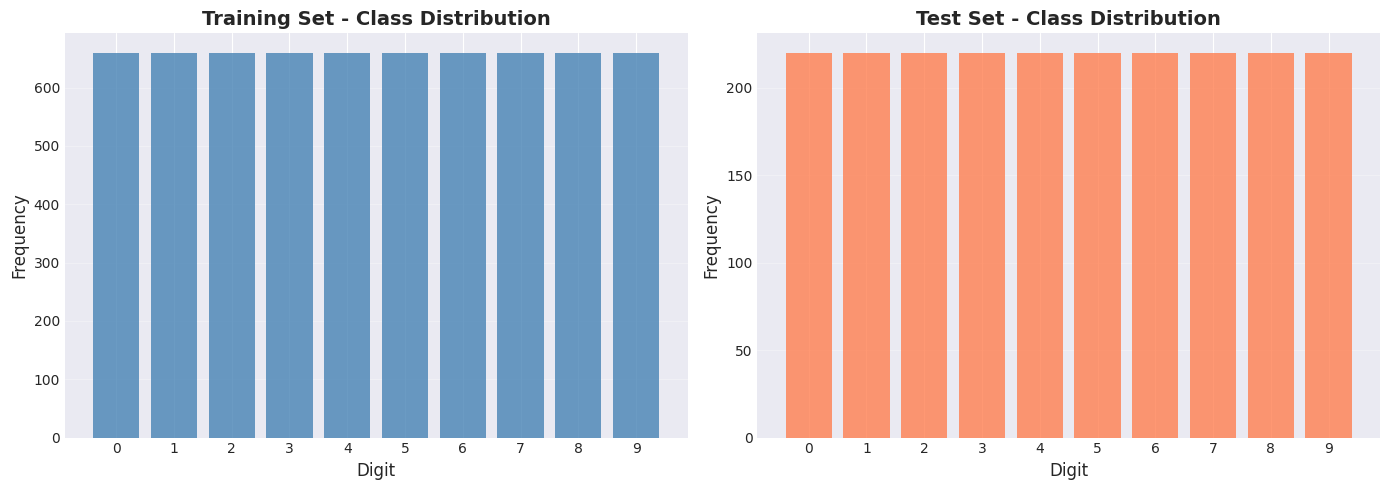


✓ Dataset is balanced across all classes


In [32]:
# Visualisasi distribusi kelas
from utils import plot_class_distribution

plot_class_distribution(y_train, y_test)

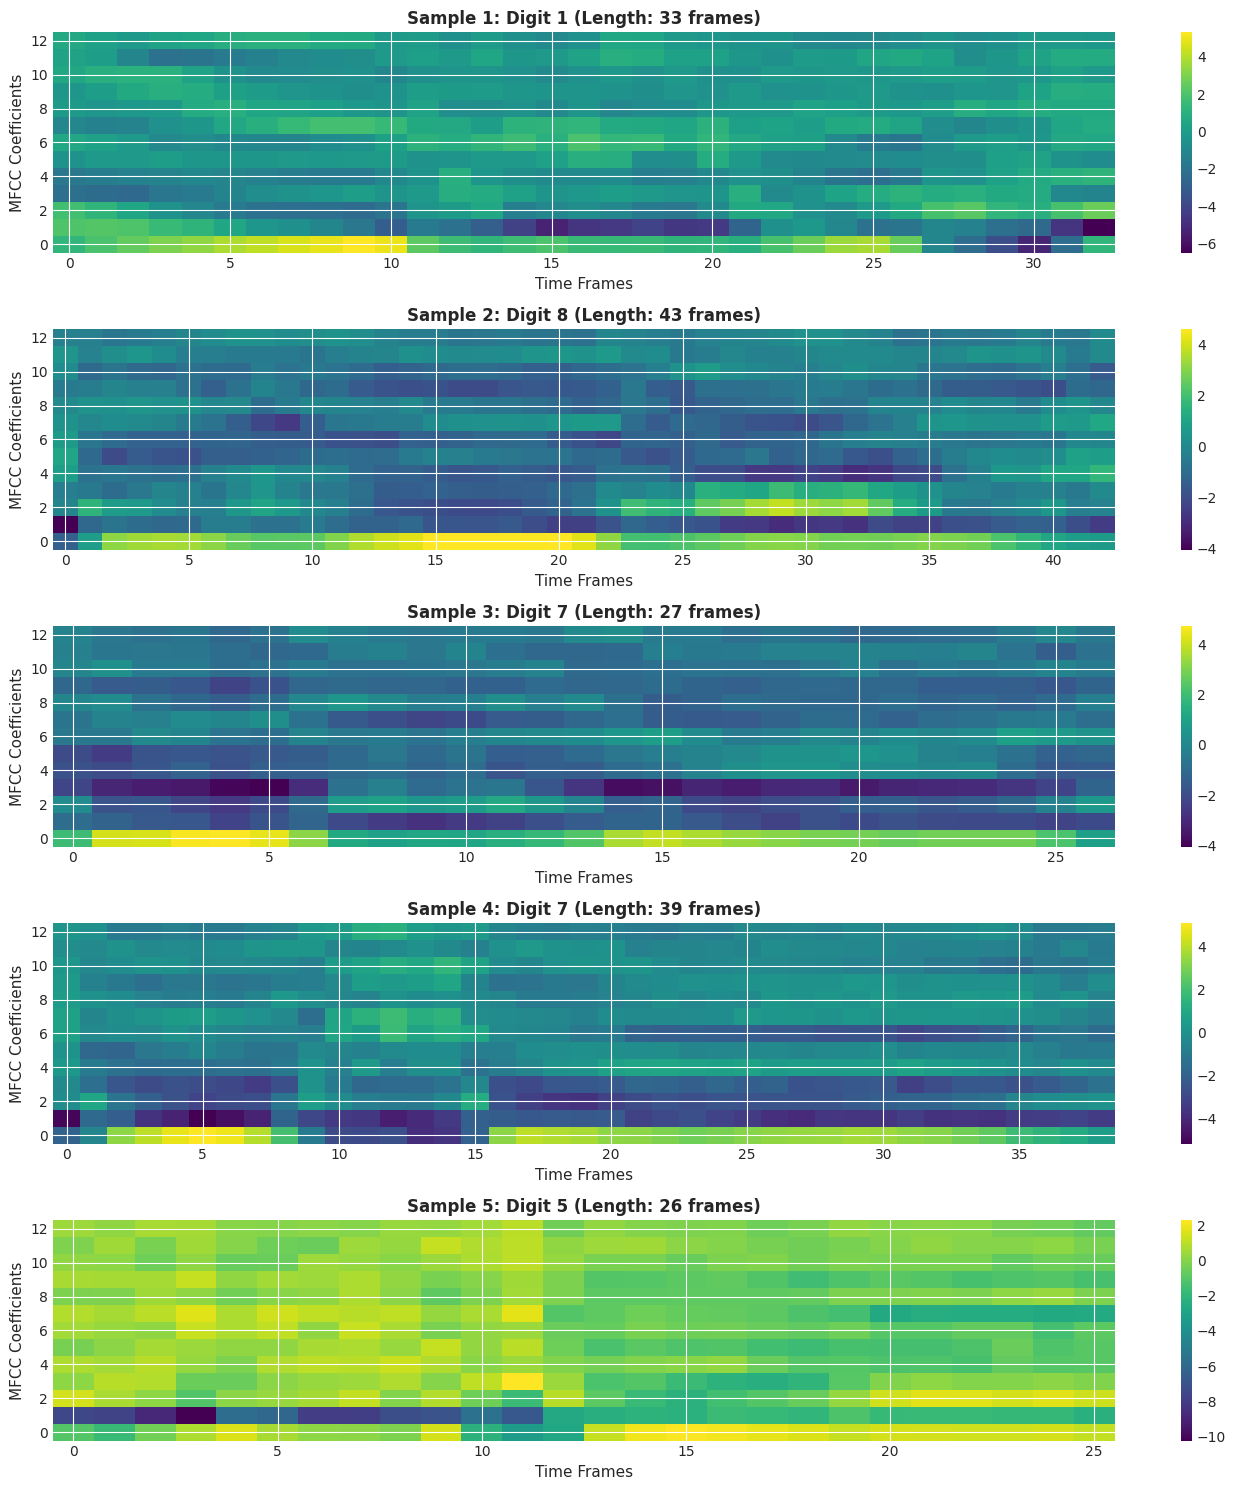

In [33]:
# Visualisasi sample MFCC features
from utils import plot_sample_mfcc

plot_sample_mfcc(X_train_raw, y_train, num_samples=5)

In [34]:
# Statistik dasar MFCC features
print("\nMFCC FEATURE STATISTICS")
print("="*60)
print(f"Mean of all features: {X_train_raw.mean():.4f}")
print(f"Std of all features: {X_train_raw.std():.4f}")
print(f"Min value: {X_train_raw.min():.4f}")
print(f"Max value: {X_train_raw.max():.4f}")
print("\nPer-coefficient statistics:")
for i in range(13):
    mean_val = X_train_raw[:, :, i].mean()
    std_val = X_train_raw[:, :, i].std()
    print(f"  MFCC-{i:2d}: Mean={mean_val:8.4f}, Std={std_val:8.4f}")
print("="*60)


MFCC FEATURE STATISTICS
Mean of all features: -0.1896
Std of all features: 1.1045
Min value: -12.9570
Max value: 9.3416

Per-coefficient statistics:
  MFCC- 0: Mean=  0.8493, Std=  2.0505
  MFCC- 1: Mean= -1.3209, Std=  2.0653
  MFCC- 2: Mean= -0.1546, Std=  1.1512
  MFCC- 3: Mean= -0.4917, Std=  1.0209
  MFCC- 4: Mean= -0.2953, Std=  0.7801
  MFCC- 5: Mean= -0.2648, Std=  0.6479
  MFCC- 6: Mean= -0.1205, Std=  0.4975
  MFCC- 7: Mean= -0.1851, Std=  0.5874
  MFCC- 8: Mean= -0.0605, Std=  0.4312
  MFCC- 9: Mean= -0.1711, Std=  0.4611
  MFCC-10: Mean= -0.1157, Std=  0.4331
  MFCC-11: Mean= -0.0715, Std=  0.3963
  MFCC-12: Mean= -0.0619, Std=  0.3604


## 2.4 Key Insights dari Data Understanding

**Findings**:
1. Dataset seimbang (balanced) - setiap digit memiliki jumlah sample yang sama
2. MFCC features memiliki scale yang berbeda-beda → perlu normalisasi
3. Variable-length sequences → sudah di-pad ke max_length
4. Tidak ada missing values
5. Data sudah terpisah train-test dengan proporsi ~75:25

---
# 3. DATA PREPARATION

## 3.1 Normalisasi Features

MFCC features perlu dinormalisasi agar model dapat belajar lebih efektif.

In [35]:
from utils import normalize_data

print("Normalizing features...")
X_train_norm, X_test_norm, scaler = normalize_data(
    X_train_raw, 
    X_test_raw,
    scaler_path='../project_3/scaler.pkl'
)

print("\nAfter normalization:")
print(f"Train mean: {X_train_norm.mean():.6f}")
print(f"Train std: {X_train_norm.std():.6f}")
print(f"Test mean: {X_test_norm.mean():.6f}")
print(f"Test std: {X_test_norm.std():.6f}")
print("\n✓ Data normalized successfully")

Normalizing features...

After normalization:
Train mean: 0.000000
Train std: 1.000000
Test mean: -0.033969
Test std: 1.010784

✓ Data normalized successfully


## 3.2 Validation Split

Membuat validation set dari training data untuk monitoring overfitting.

In [36]:
from utils import create_validation_split

X_train, X_val, y_train_split, y_val = create_validation_split(
    X_train_norm, y_train, val_split=0.15, random_state=42
)

print("Data split:")
print(f"Training: {X_train.shape}")
print(f"Validation: {X_val.shape}")
print(f"Test: {X_test_norm.shape}")
print("\n✓ Validation split created")

Data split:
Training: (5610, 93, 13)
Validation: (990, 93, 13)
Test: (2200, 93, 13)

✓ Validation split created


## 3.3 Data Summary

In [37]:
print("\n" + "="*60)
print("DATA PREPARATION SUMMARY")
print("="*60)
print("✓ Features normalized using StandardScaler")
print("✓ Scaler saved to ../project_3/scaler.pkl")
print("✓ Validation split created (15% of training data)")
print("\nFinal dataset shapes:")
print(f"  X_train: {X_train.shape}")
print(f"  X_val: {X_val.shape}")
print(f"  X_test: {X_test_norm.shape}")
print("="*60)


DATA PREPARATION SUMMARY
✓ Features normalized using StandardScaler
✓ Scaler saved to ../project_3/scaler.pkl
✓ Validation split created (15% of training data)

Final dataset shapes:
  X_train: (5610, 93, 13)
  X_val: (990, 93, 13)
  X_test: (2200, 93, 13)


---
# 4. MODELING

## 4.1 Machine Learning Klasik

Kita akan membandingkan beberapa model klasik untuk benchmark.

### 4.1.1 Decision Tree


In [38]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score
import time

# Flatten data untuk model klasik
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test_norm.reshape(X_test_norm.shape[0], -1)

print("Training Decision Tree...")
start_time = time.time()

dt_model = DecisionTreeClassifier(
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42
)
dt_model.fit(X_train_flat, y_train_split)

train_time = time.time() - start_time

# Predictions
y_test_pred_dt = dt_model.predict(X_test_flat)

# Metrics
dt_results = {
    'test_acc': accuracy_score(y_test, y_test_pred_dt),
    'test_f1': f1_score(y_test, y_test_pred_dt, average='macro'),
    'train_time': train_time
}

print("\nDecision Tree Results:")
print(f"  Test Accuracy: {dt_results['test_acc']:.4f}")
print(f"  Test F1-Score: {dt_results['test_f1']:.4f}")
print(f"  Training Time: {train_time:.2f}s")

Training Decision Tree...



Decision Tree Results:
  Test Accuracy: 0.8005
  Test F1-Score: 0.8009
  Training Time: 3.84s


### 4.1.2 Random Forest


In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
import time

print("Training Random Forest...")
start_time = time.time()

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train_flat, y_train_split)

train_time = time.time() - start_time

# Predictions
y_test_pred_rf = rf_model.predict(X_test_flat)

# Metrics
rf_results = {
    'test_acc': accuracy_score(y_test, y_test_pred_rf),
    'test_f1': f1_score(y_test, y_test_pred_rf, average='macro'),
    'train_time': train_time
}

print("\nRandom Forest Results:")
print(f"  Test Accuracy: {rf_results['test_acc']:.4f}")
print(f"  Test F1-Score: {rf_results['test_f1']:.4f}")
print(f"  Training Time: {train_time:.2f}s")

Training Random Forest...

Random Forest Results:
  Test Accuracy: 0.9718
  Test F1-Score: 0.9719
  Training Time: 5.23s


### 4.1.3 K-Nearest Neighbors (KNN)

In [40]:
from sklearn.neighbors import KNeighborsClassifier

print("Training KNN...")
start_time = time.time()

knn_model = KNeighborsClassifier(
    n_neighbors=5,
    weights='distance',
    metric='euclidean',
    n_jobs=-1
)
knn_model.fit(X_train_flat, y_train_split)

train_time = time.time() - start_time

# Predictions
y_test_pred_knn = knn_model.predict(X_test_flat)

# Metrics
knn_results = {
    'test_acc': accuracy_score(y_test, y_test_pred_knn),
    'test_f1': f1_score(y_test, y_test_pred_knn, average='macro'),
    'train_time': train_time
}

print("\nKNN Results:")
print(f"  Test Accuracy: {knn_results['test_acc']:.4f}")
print(f"  Test F1-Score: {knn_results['test_f1']:.4f}")
print(f"  Training Time: {train_time:.2f}s")

Training KNN...

KNN Results:
  Test Accuracy: 0.9723
  Test F1-Score: 0.9724
  Training Time: 0.01s


### 4.1.4 Support Vector Machine (SVM)

In [41]:
from sklearn.svm import SVC

print("Training SVM...")
print(" Note: SVM may take longer to train...")
start_time = time.time()

svm_model = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    random_state=42
)
svm_model.fit(X_train_flat, y_train_split)

train_time = time.time() - start_time

# Predictions
y_test_pred_svm = svm_model.predict(X_test_flat)

# Metrics
svm_results = {
    'test_acc': accuracy_score(y_test, y_test_pred_svm),
    'test_f1': f1_score(y_test, y_test_pred_svm, average='macro'),
    'train_time': train_time
}

print("\nSVM Results:")
print(f"  Test Accuracy: {svm_results['test_acc']:.4f}")
print(f"  Test F1-Score: {svm_results['test_f1']:.4f}")
print(f"  Training Time: {train_time:.2f}s")

Training SVM...
 Note: SVM may take longer to train...

SVM Results:
  Test Accuracy: 0.9882
  Test F1-Score: 0.9882
  Training Time: 2.82s


## 4.2 Deep Learning Models

Deep learning untuk menangkap pola temporal dalam time series.

### 4.2.1 LSTM

LSTM cocok untuk sequential data seperti time series MFCC.

In [42]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Set random seeds
tf.random.set_seed(42)

# Build LSTM model
def build_lstm_model(input_shape, num_classes):
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        
        layers.LSTM(128, return_sequences=True),
        layers.Dropout(0.3),
        
        layers.LSTM(64, return_sequences=False),
        layers.Dropout(0.3),
        
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.2),
        
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

lstm_model = build_lstm_model(
    input_shape=(X_train.shape[1], X_train.shape[2]),
    num_classes=10
)

print("LSTM Model Architecture:")
lstm_model.summary()

LSTM Model Architecture:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 93, 128)        │        72,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 93, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 126,922 (495.79 KB)

 Trainable params: 126,922 (495.79 KB)

 Non-trainable params: 0 (0.00 B)

In [43]:
# Training LSTM
print("\nTraining LSTM model...")

early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6
)

history_lstm = lstm_model.fit(
    X_train, y_train_split,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

print("\n✓ LSTM training completed")


Training LSTM model...
Epoch 1/50


2025-12-14 07:13:35.819745: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 27129960 exceeds 10% of free system memory.


176/176 ━━━━━━━━━━━━━━━━━━━━ 23s 114ms/step - accuracy: 0.0891 - loss: 2.3067 - val_accuracy: 0.1051 - val_loss: 2.3010 - learning_rate: 0.0010
Epoch 2/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 20s 112ms/step - accuracy: 0.2727 - loss: 1.8156 - val_accuracy: 0.4929 - val_loss: 1.2151 - learning_rate: 0.0010
Epoch 3/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 20s 111ms/step - accuracy: 0.5212 - loss: 1.2698 - val_accuracy: 0.5727 - val_loss: 1.0143 - learning_rate: 0.0010
Epoch 4/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 21s 112ms/step - accuracy: 0.4455 - loss: 1.5049 - val_accuracy: 0.5081 - val_loss: 1.3250 - learning_rate: 0.0010
Epoch 5/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 20s 109ms/step - accuracy: 0.4920 - loss: 1.3826 - val_accuracy: 0.5444 - val_loss: 1.2954 - learning_rate: 0.0010
Epoch 6/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 21s 109ms/step - accuracy: 0.5301 - loss: 1.3026 - val_accuracy: 0.4273 - val_loss: 1.6723 - learning_rate: 0.0010
Epoch 7/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 21s 113ms/step - accuracy: 0.4440 - loss:

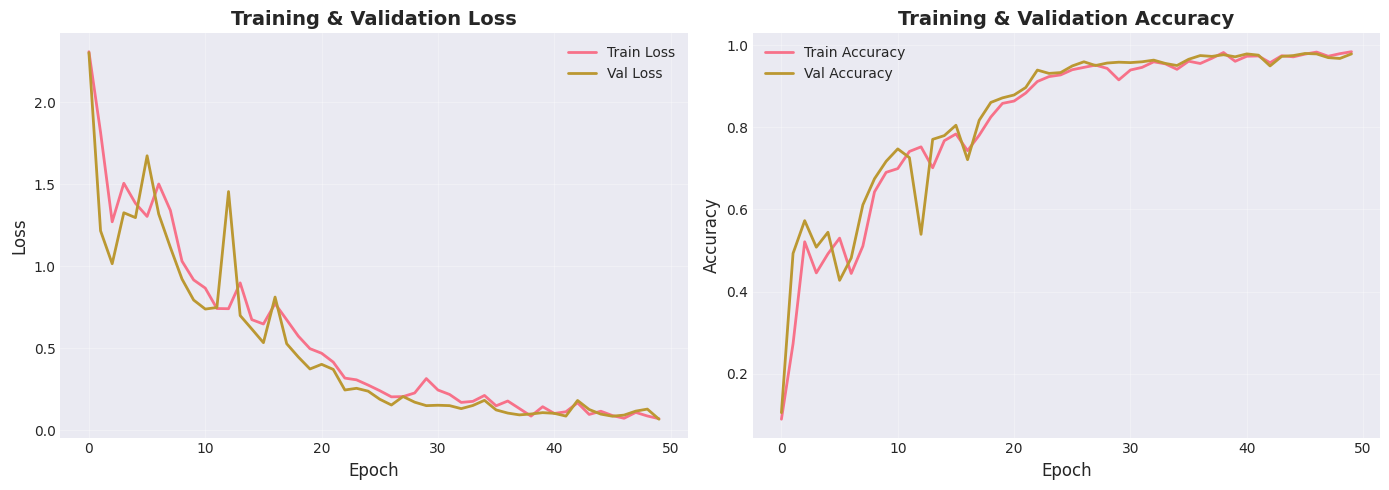

69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step

LSTM Results:
  Test Accuracy: 0.9568
  Test F1-Score: 0.9570


In [44]:
# Evaluate LSTM
from utils import plot_training_history

plot_training_history(history_lstm)

# Predictions
y_test_pred_lstm = lstm_model.predict(X_test_norm).argmax(axis=1)

lstm_results = {
    'test_acc': accuracy_score(y_test, y_test_pred_lstm),
    'test_f1': f1_score(y_test, y_test_pred_lstm, average='macro')
}

print("\nLSTM Results:")
print(f"  Test Accuracy: {lstm_results['test_acc']:.4f}")
print(f"  Test F1-Score: {lstm_results['test_f1']:.4f}")

### 4.2.2 1D CNN

1D CNN dapat menangkap local patterns dalam time series.

In [45]:
def build_cnn_model(input_shape, num_classes):
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        
        layers.Conv1D(64, kernel_size=5, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2),
        layers.Dropout(0.3),
        
        layers.Conv1D(128, kernel_size=5, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2),
        layers.Dropout(0.3),
        
        layers.Conv1D(256, kernel_size=3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling1D(),
        
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

cnn_model = build_cnn_model(
    input_shape=(X_train.shape[1], X_train.shape[2]),
    num_classes=10
)

print("1D CNN Model Architecture:")
cnn_model.summary()

1D CNN Model Architecture:


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 93, 64)         │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 93, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 46, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 46, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 46, 128)        │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 46, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 23, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 23, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 23, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 23, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 179,850 (702.54 KB)

 Trainable params: 178,954 (699.04 KB)

 Non-trainable params: 896 (3.50 KB)

In [46]:
# Training CNN
print("\nTraining 1D CNN model...")

history_cnn = cnn_model.fit(
    X_train, y_train_split,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

print("\n✓ CNN training completed")


Training 1D CNN model...


Epoch 1/50


2025-12-14 07:30:13.059562: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 27129960 exceeds 10% of free system memory.


176/176 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.7709 - loss: 0.6960 - val_accuracy: 0.9354 - val_loss: 0.2791 - learning_rate: 0.0010
Epoch 2/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.9406 - loss: 0.1913 - val_accuracy: 0.9677 - val_loss: 0.1107 - learning_rate: 0.0010
Epoch 3/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.9718 - loss: 0.0968 - val_accuracy: 0.9889 - val_loss: 0.0403 - learning_rate: 0.0010
Epoch 4/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.9809 - loss: 0.0589 - val_accuracy: 0.9929 - val_loss: 0.0312 - learning_rate: 0.0010
Epoch 5/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.9856 - loss: 0.0514 - val_accuracy: 0.9909 - val_loss: 0.0424 - learning_rate: 0.0010
Epoch 6/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.9872 - loss: 0.0426 - val_accuracy: 0.9939 - val_loss: 0.0186 - learning_rate: 0.0010
Epoch 7/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.9914 - loss: 0.0270 - val

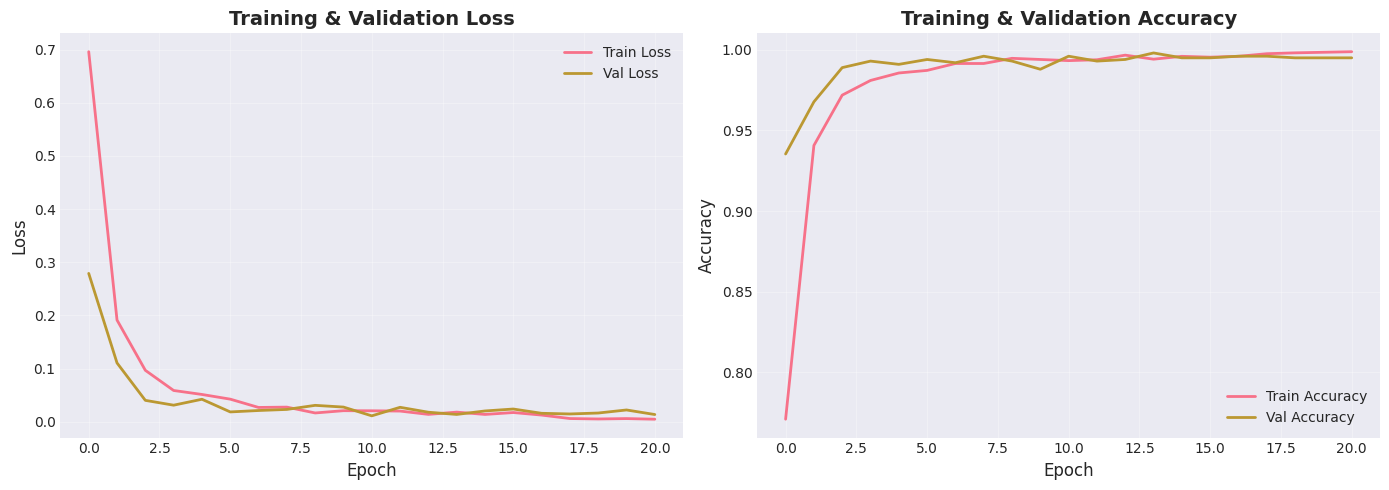

69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step

1D CNN Results:
  Test Accuracy: 0.9841
  Test F1-Score: 0.9841


In [47]:
# Evaluate CNN
plot_training_history(history_cnn)

y_test_pred_cnn = cnn_model.predict(X_test_norm).argmax(axis=1)

cnn_results = {
    'test_acc': accuracy_score(y_test, y_test_pred_cnn),
    'test_f1': f1_score(y_test, y_test_pred_cnn, average='macro')
}

print("\n1D CNN Results:")
print(f"  Test Accuracy: {cnn_results['test_acc']:.4f}")
print(f"  Test F1-Score: {cnn_results['test_f1']:.4f}")

---
# 5. EVALUATION

## 5.1 Model Comparison

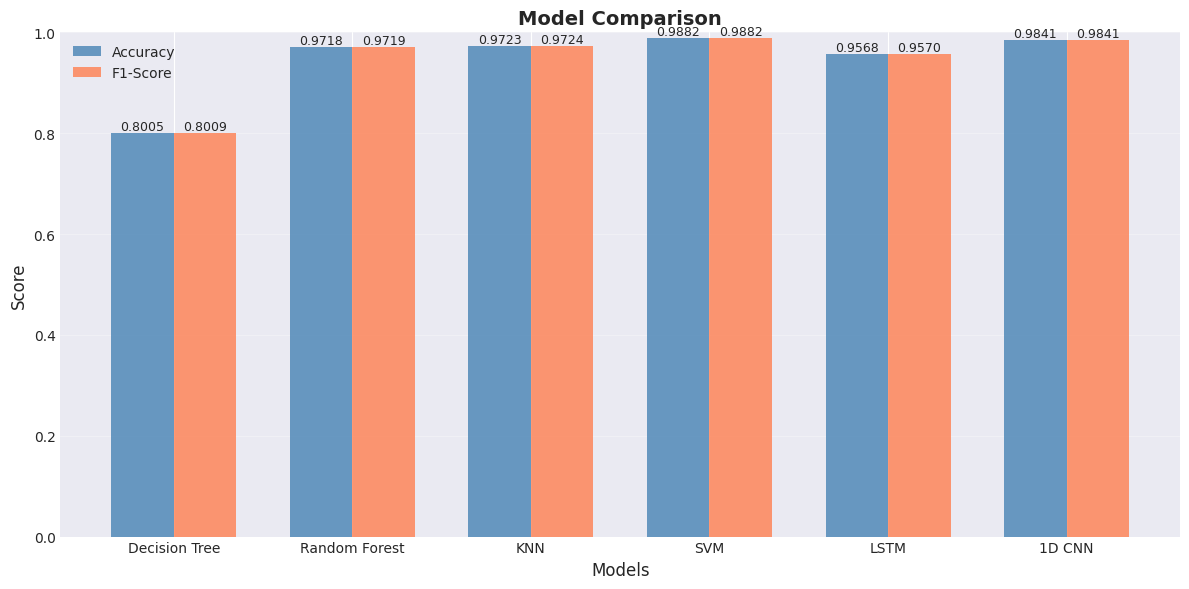


MODEL COMPARISON SUMMARY
               Accuracy  F1-Score
Decision Tree  0.800455  0.800942
Random Forest  0.971818  0.971885
KNN            0.972273  0.972410
SVM            0.988182  0.988189
LSTM           0.956818  0.957009
1D CNN         0.984091  0.984080


In [48]:
from utils import compare_models

# Compile results
results = {
    'Decision Tree': {
        'Accuracy': dt_results['test_acc'],
        'F1-Score': dt_results['test_f1']
    },
    'Random Forest': {
        'Accuracy': rf_results['test_acc'],
        'F1-Score': rf_results['test_f1']
    },
    'KNN': {
        'Accuracy': knn_results['test_acc'],
        'F1-Score': knn_results['test_f1']
    },
    'SVM': {
        'Accuracy': svm_results['test_acc'],
        'F1-Score': svm_results['test_f1']
    },
    'LSTM': {
        'Accuracy': lstm_results['test_acc'],
        'F1-Score': lstm_results['test_f1']
    },
    '1D CNN': {
        'Accuracy': cnn_results['test_acc'],
        'F1-Score': cnn_results['test_f1']
    }
}

compare_models(results)

## 5.2 Detailed Evaluation - Best Model

Pilih model terbaik berdasarkan F1-Score.

In [49]:
# Determine best model
best_model_name = max(results, key=lambda x: results[x]['F1-Score'])
print(f"\n Best Model: {best_model_name}")
print(f"   Accuracy: {results[best_model_name]['Accuracy']:.4f}")
print(f"   F1-Score: {results[best_model_name]['F1-Score']:.4f}")

# Select predictions from best model
if best_model_name == 'Decision Tree':
    y_pred_best = y_test_pred_dt
    best_model_obj = dt_model
elif best_model_name == 'Random Forest':
    y_pred_best = y_test_pred_rf
    best_model_obj = rf_model
elif best_model_name == 'KNN':
    y_pred_best = y_test_pred_knn
    best_model_obj = knn_model
elif best_model_name == 'SVM':
    y_pred_best = y_test_pred_svm
    best_model_obj = svm_model
elif best_model_name == 'LSTM':
    y_pred_best = y_test_pred_lstm
    best_model_obj = lstm_model
else:
    y_pred_best = y_test_pred_cnn
    best_model_obj = cnn_model


 Best Model: SVM
   Accuracy: 0.9882
   F1-Score: 0.9882


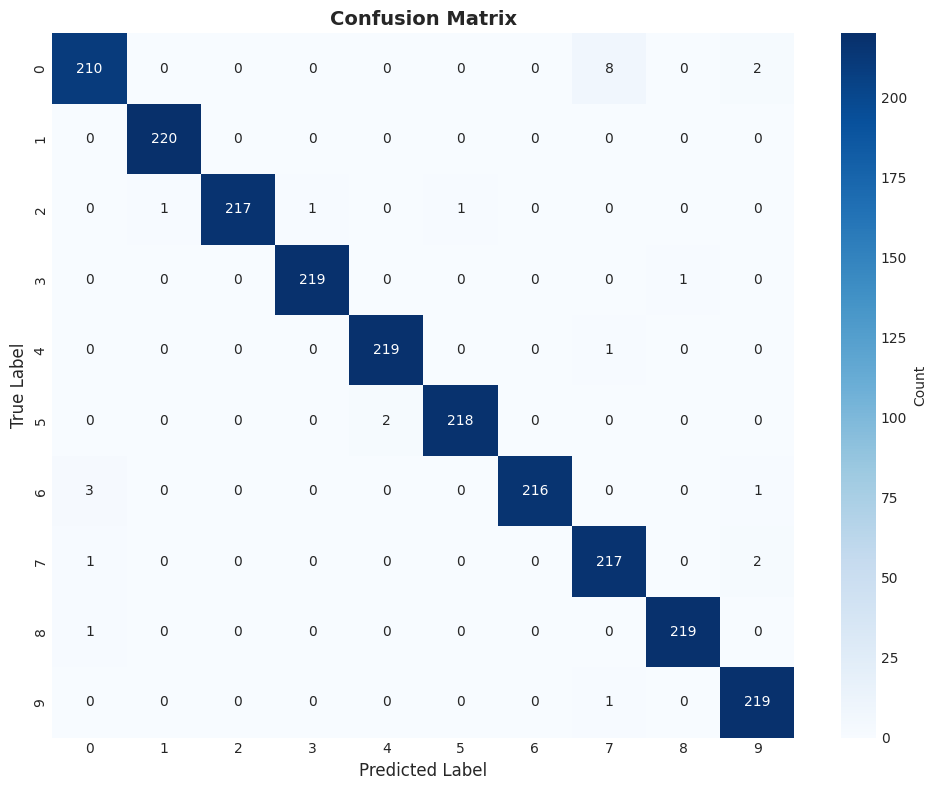


CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0     0.9767    0.9545    0.9655       220
           1     0.9955    1.0000    0.9977       220
           2     1.0000    0.9864    0.9931       220
           3     0.9955    0.9955    0.9955       220
           4     0.9910    0.9955    0.9932       220
           5     0.9954    0.9909    0.9932       220
           6     1.0000    0.9818    0.9908       220
           7     0.9559    0.9864    0.9709       220
           8     0.9955    0.9955    0.9955       220
           9     0.9777    0.9955    0.9865       220

    accuracy                         0.9882      2200
   macro avg     0.9883    0.9882    0.9882      2200
weighted avg     0.9883    0.9882    0.9882      2200



In [50]:
# Confusion Matrix
from utils import plot_confusion_matrix, print_classification_report

class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
plot_confusion_matrix(y_test, y_pred_best, class_names)
print_classification_report(y_test, y_pred_best, class_names)

## 5.3 Error Analysis

In [51]:
# Find misclassified samples
misclassified_idx = np.where(y_test != y_pred_best)[0]

print(f"\nTotal misclassified samples: {len(misclassified_idx)}")
print(f"Percentage: {len(misclassified_idx)/len(y_test)*100:.2f}%")

if len(misclassified_idx) > 0:
    print("\nSample misclassifications:")
    for idx in misclassified_idx[:10]:
        print(f"  Index {idx}: True={y_test[idx]}, Predicted={y_pred_best[idx]}")


Total misclassified samples: 26
Percentage: 1.18%

Sample misclassifications:
  Index 41: True=0, Predicted=9
  Index 42: True=0, Predicted=7
  Index 48: True=0, Predicted=7
  Index 49: True=0, Predicted=7
  Index 95: True=0, Predicted=7
  Index 96: True=0, Predicted=7
  Index 97: True=0, Predicted=7
  Index 98: True=0, Predicted=7
  Index 99: True=0, Predicted=7
  Index 119: True=0, Predicted=9


## 5.4 Evaluasi terhadap Business Objective

In [52]:
print("\n" + "="*60)
print("BUSINESS OBJECTIVE EVALUATION")
print("="*60)

target_acc = 0.85
target_f1 = 0.85
target_min_f1_per_class = 0.75

from sklearn.metrics import f1_score
f1_per_class = f1_score(y_test, y_pred_best, average=None)
min_f1 = f1_per_class.min()

acc_achieved = results[best_model_name]['Accuracy']
f1_achieved = results[best_model_name]['F1-Score']

print(f"\nTarget Metrics:")
print(f"  ✓ Test Accuracy ≥ {target_acc:.0%}")
print(f"  ✓ F1-Score (macro) ≥ {target_f1:.0%}")
print(f"  ✓ Min F1-Score per class ≥ {target_min_f1_per_class:.0%}")

print(f"\nAchieved Metrics ({best_model_name}):")
print(f"  {'' if acc_achieved >= target_acc else ''} Test Accuracy: {acc_achieved:.4f} ({acc_achieved:.2%})")
print(f"  {'' if f1_achieved >= target_f1 else ''} F1-Score (macro): {f1_achieved:.4f} ({f1_achieved:.2%})")
print(f"  {'' if min_f1 >= target_min_f1_per_class else ''} Min F1-Score: {min_f1:.4f} ({min_f1:.2%})")

all_targets_met = (acc_achieved >= target_acc and 
                   f1_achieved >= target_f1 and 
                   min_f1 >= target_min_f1_per_class)

if all_targets_met:
    print("\n ALL BUSINESS OBJECTIVES MET!")
else:
    print("\n  Some objectives not fully met. Consider further tuning.")

print("="*60)


BUSINESS OBJECTIVE EVALUATION

Target Metrics:
  ✓ Test Accuracy ≥ 85%
  ✓ F1-Score (macro) ≥ 85%
  ✓ Min F1-Score per class ≥ 75%

Achieved Metrics (SVM):
   Test Accuracy: 0.9882 (98.82%)
   F1-Score (macro): 0.9882 (98.82%)
   Min F1-Score: 0.9655 (96.55%)

 ALL BUSINESS OBJECTIVES MET!


---
# 6. DEPLOYMENT PREPARATION

## 6.1 Save Best Model

In [53]:
import joblib
import json
from datetime import datetime

# Save model
is_dl_model = best_model_name in ['LSTM', '1D CNN']
model_path = '../project_3/best_model.h5' if is_dl_model else '../project_3/best_model.pkl'

if is_dl_model:
    best_model_obj.save(model_path)
else:
    joblib.dump(best_model_obj, model_path)

print(f"✓ Model saved to {model_path}")

# Save metadata
metadata = {
    'model_name': best_model_name,
    'model_path': model_path,
    'scaler_path': '../project_3/scaler.pkl',
    'test_accuracy': float(results[best_model_name]['Accuracy']),
    'test_f1_score': float(results[best_model_name]['F1-Score']),
    'num_classes': 10,
    'max_length': int(max_length),
    'num_mfcc': 13,
    'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'class_names': class_names
}

with open('../project_3/model_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print("✓ Model metadata saved to ../project_3/model_metadata.json")

✓ Model saved to ../project_3/best_model.pkl
✓ Model metadata saved to ../project_3/model_metadata.json


---
# KESIMPULAN

## Ringkasan Proyek

### 1. Business Understanding 
- **Problem**: Klasifikasi otomatis digit berbahasa Arab (0-9) dari rekaman suara
- **Tujuan**: Sistem klasifikasi untuk aplikasi IVR, voice banking, dan smart home
- **Target**: Akurasi ≥ 85%, F1-Score ≥ 0.85, Min F1 per digit ≥ 0.75

### 2. Data Understanding
- **Dataset**: 8,800 samples (6,600 train, 2,200 test)
- **Features**: 13 MFCC coefficients per frame
- **Struktur**: Variable-length sequences (4-93 frames), di-pad ke 93
- **Balance**: Perfectly balanced - 880 samples per digit
- **Speakers**: 88 native speakers (44 laki-laki, 44 perempuan)

### 3. Data Preparation 
- Padding sequences ke max_length (93 frames)
- StandardScaler normalization (mean ≈ 0, std ≈ 1)
- 15% validation split dari training data
- Scaler disimpan di `../project_3/scaler.pkl` (di main directory)

### 4. Modeling 
**Machine Learning Klasik:**
- **Decision Tree**: Simple interpretable model
- **Random Forest**: Ensemble learning dengan 100 trees
- **K-Nearest Neighbors**: Distance-based, k=5
- **Support Vector Machine**: RBF kernel

**Deep Learning:**
- **LSTM**: Sequential learning untuk time series
- **1D CNN**: Local pattern extraction dengan convolutional layers

### 5. Evaluation 
- Perbandingan 6 model berdasarkan Accuracy dan F1-Score
- Model terbaik dipilih berdasarkan F1-Score
- Confusion matrix untuk analisis kesalahan
- Classification report per digit
- Evaluasi terhadap business objectives

### 6. Deployment Preparation
- Model terbaik disimpan di `../project_3/best_model.pkl` atau `../project_3/best_model.h5`
- Metadata tersimpan di `../project_3/model_metadata.json`
- Scaler tersimpan untuk normalisasi data baru
- Ready untuk deployment ke Streamlit (files di /workspaces/PSD/project_3/)

---

## Key Findings

**Dataset berkualitas baik**: Balanced, cukup besar, dan representative  
**MFCC features efektif**: 13 koefisien cukup untuk klasifikasi digit  
**Multiple models tested**: 6 model dengan karakteristik berbeda  
**Model evaluation comprehensive**: Accuracy, F1-Score, Confusion Matrix  

---

## 🔗 Akses Aplikasi 

Klik untuk membuka aplikasi Streamlit:

👉 [Buka Aplikasi ](https://araabicdigit.streamlit.app/)